In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from urllib.parse import unquote
import numpy as np
import os
import seaborn as sns
import networkx as nx

from src.preprocessing import WikispeediaData
from src.analysis_helpers import *
from src.plot_functions import *
from src.hubs_analysis import *
from src.pagerankVSfreqeuency import *
from src.fork import *

### Reading data
Reading data and preprocessing it in WikispeediaData class

In [2]:
#Takes some time to run!
data = WikispeediaData()

data.count_articles()

In [3]:
df_hubs = get_hubs_dataframe(data)

In [4]:
#Printing statistics for dataframe
df_hubs[['source_counts', 'target_counts','mean_shortest_path_to_article','mean_shortest_path']].describe()

,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path
count,4604.000000,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,2.829412,3.188769
std,24.201491,62.746827,1.170888,0.321702
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,2.626172,3.025154
50%,19.000000,8.000000,2.989640,3.179408
75%,33.000000,25.000000,3.476390,3.344081
max,294.000000,1551.000000,6.866085,5.119852


In [5]:
min_indices = df_hubs[df_hubs["mean_shortest_path"] < 1].index

print('Number of articles with min distance')
article_names_at_min_indices = df_hubs["article_names"].iloc[min_indices]
print(len(article_names_at_min_indices))

Number of articles with min distance
19


In [6]:
df_hubs_filtered = df_hubs.drop(min_indices)

top_10_shortest_path = df_hubs_filtered.nsmallest(15, 'mean_shortest_path')[['article_names', 'mean_shortest_path']]

print('Articles with mean shortest path to other articles:')
print(top_10_shortest_path)

Articles with mean shortest path to other articles:
                     article_names  mean_shortest_path
4297                 United States            2.484834
39                    21st century            2.563502
1989          History of the world            2.578792
331                      Argentina            2.586436
24                    19th century            2.596054
4293                United Kingdom            2.606165
1247  Driving on the left or right            2.609467
128                         Africa            2.622935
3966                      Swastika            2.626387
1694                       Germany            2.626880
2433                       Lebanon            2.645376
4424                         Water            2.647842
1433                        Europe            2.648335
694                 British Empire            2.649075
2177                        Israel            2.649322


### Plotting distributions 
Plotting distributions of number of links in articles, number of links to articles, categories, mean shortest path distance from articles, mean shorest distance to article. 

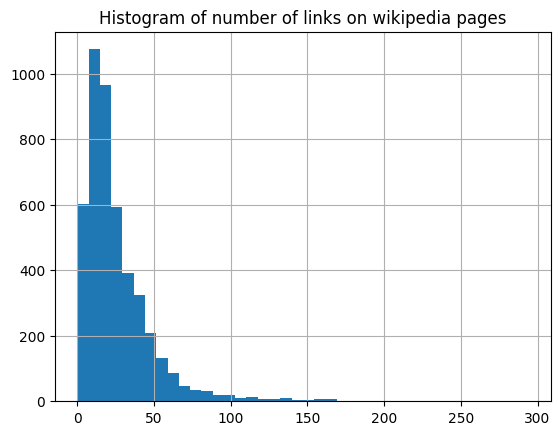

In [7]:
#Plotting distribution of links on wikipages
df_hubs.hist(column = "source_counts", bins = 40)
plt.title('Histogram of number of links on wikipedia pages')
plt.show()

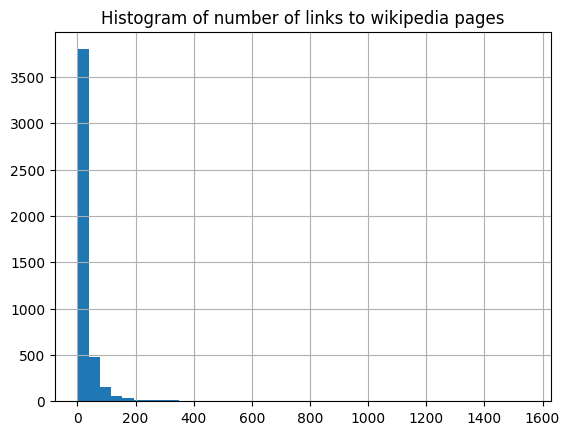

In [8]:
#Plotting distribution of links to wikipages
df_hubs.hist(column = "target_counts", bins = 40)
plt.title('Histogram of number of links to wikipedia pages')
plt.show()

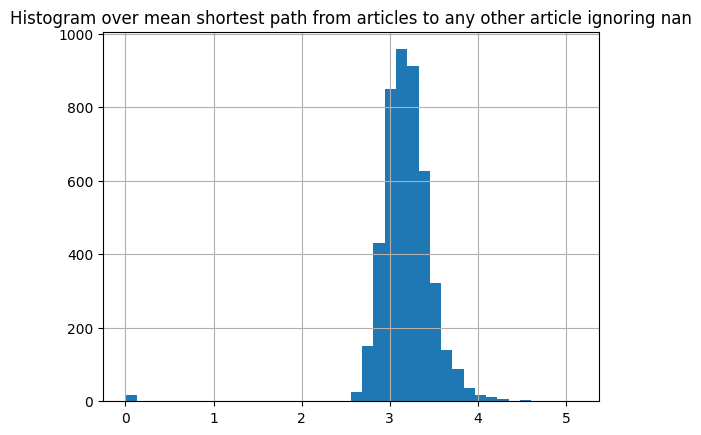

In [9]:
df_hubs.hist(column = "mean_shortest_path", bins = 40)
plt.title('Histogram over mean shortest path from articles to any other article ignoring nan')
plt.show()

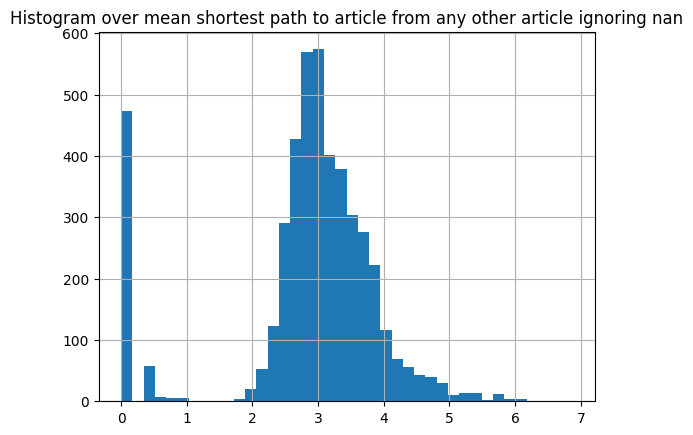

In [10]:
df_hubs.hist(column = "mean_shortest_path_to_article", bins = 40)
plt.title('Histogram over mean shortest path to article from any other article ignoring nan')
plt.show()

### Looking at some extreme values

In [11]:
#Looking at values which have mean shortest path 0
min_value = df_hubs["mean_shortest_path"].min()

min_indices = df_hubs["article_names"].index[df_hubs["mean_shortest_path"] == min_value].tolist()

print('Articles with min distance', min_value)
df_hubs["article_names"].iloc[min_indices]

Articles with min distance 0.0


441                                                Badugi
970                                Color Graphics Adapter
1210                                          Directdebit
1231                                             Donation
1237                                         Douglas DC-4
1257                          Duchenne muscular dystrophy
2351                               Klinefelter's syndrome
2530                                      Local community
2543                                Lone Wolf (gamebooks)
3108                                         Osteomalacia
3352                                     Private Peaceful
3645                                        Schatzki ring
3928                                          Suikinkutsu
4289                                Underground (stories)
4333                                           Vacutainer
4480    Wikipedia Text of the GNU Free Documentation L...
4545                                          Wowpurchase
Name: article_

### Some basic plots exploring the data 

In [12]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


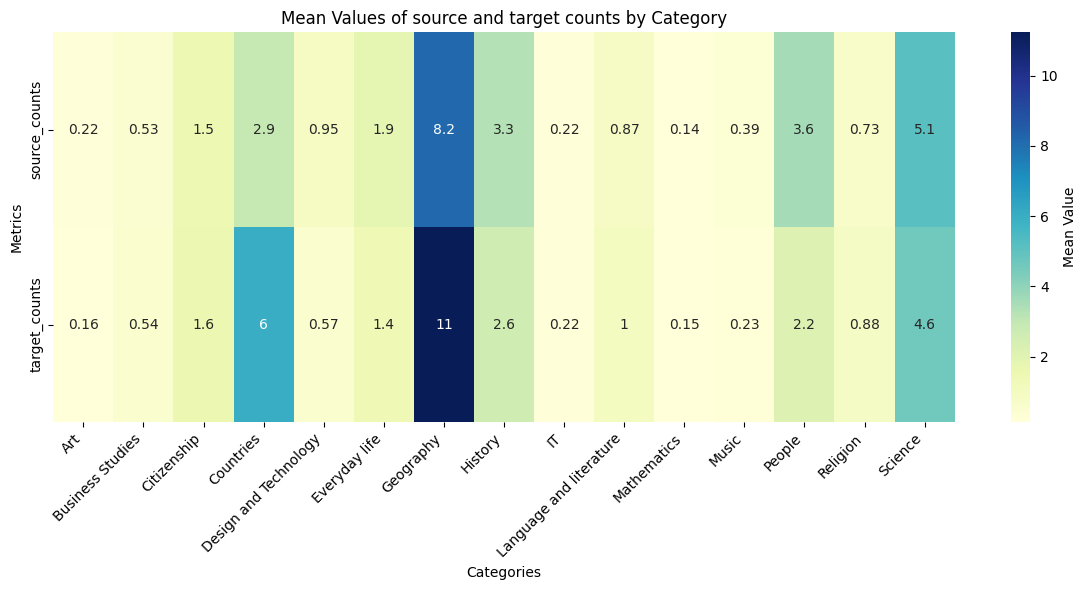

In [13]:

mean_values = df_hubs[["source_counts", "target_counts"]].mean()
categories = df_hubs.columns[5:]

# Create matrix for plotting
matrix = pd.DataFrame({
    "source_counts": df_hubs[categories].multiply(df_hubs["source_counts"], axis=0).mean(),
    "target_counts": df_hubs[categories].multiply(df_hubs["target_counts"], axis=0).mean()}).T

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'})
plt.title('Mean Values of source and target counts by Category')
plt.xlabel('Categories')
plt.ylabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
#Looked at correlation between variables not sure if this is relevant to our analysis?
correlation_matrix = df_hubs[['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path']].corr()

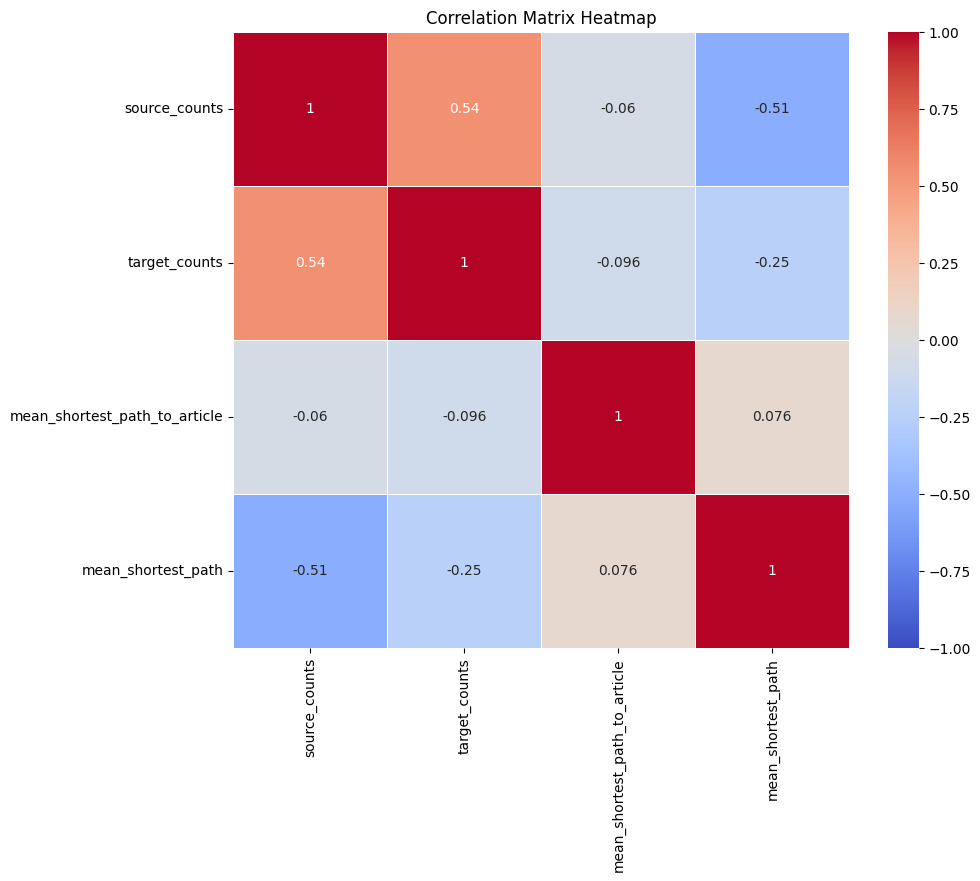

In [15]:
correlation_matrix = df_hubs[['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path']].corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

### Looking at distribution of categories

How to deal with articles which are apart of more than 1 main category?

Text(0, 0.5, 'Frequency')

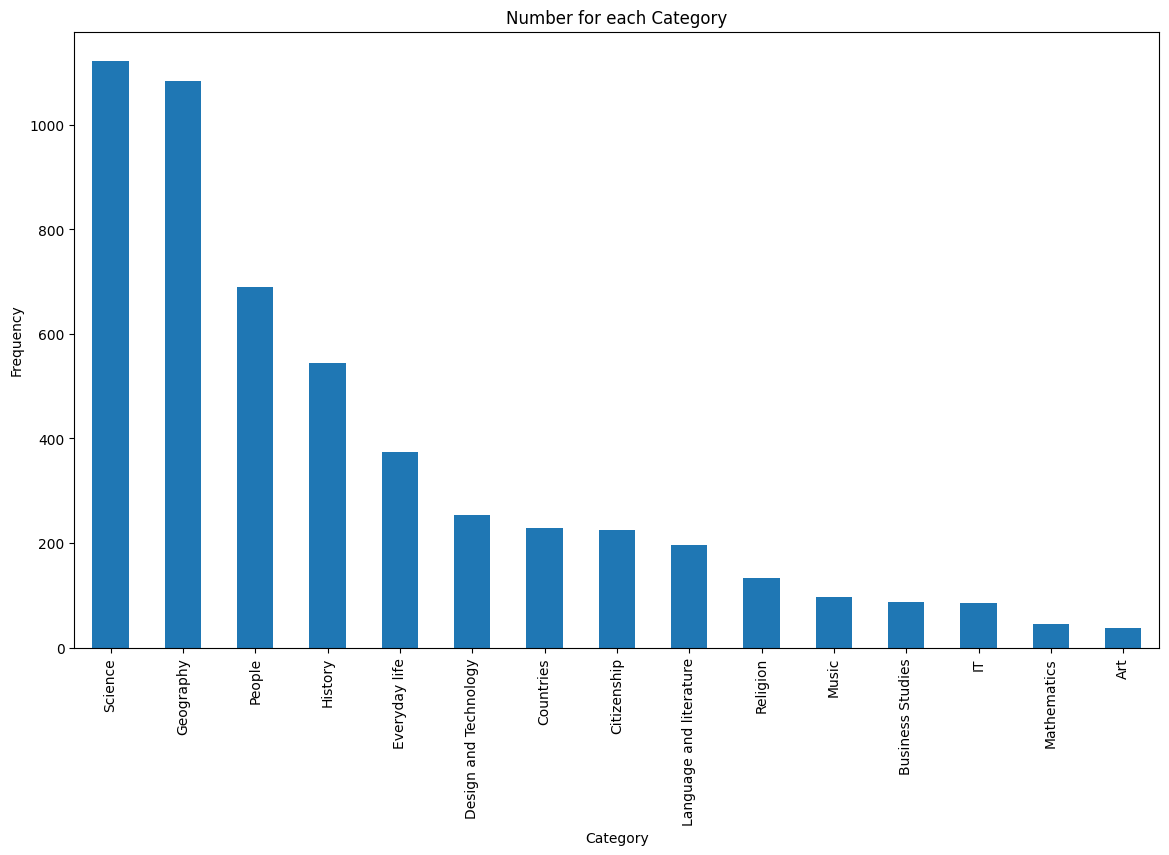

In [16]:
ax = data.categories['1st cat'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Category")
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")

#### Implement PageRank

In [17]:
# Create a graph
G = nx.DiGraph()

# Add edges from the links data
edges = list(zip(data.links['1st article'], data.links['2nd article']))
G.add_edges_from(edges)

# calculate PageRank
pagerank_scores = nx.pagerank(G)

# Add PageRank scores to df_hubs
df_hubs["pagerank_score"] = df_hubs["article_names"].map(pagerank_scores).fillna(0)

# show top hubs by PageRank
columns_disp = [
    "article_names", 
    "source_counts", 
    "target_counts", 
    "mean_shortest_path_to_article", 
    "mean_shortest_path", 
    "pagerank_score"
]

# Sort and display the selected columns
top_hubs_pr = df_hubs.sort_values(by="pagerank_score", ascending=False).head(5)[columns_disp]
top_hubs_msp = df_hubs.sort_values(by="target_counts", ascending=False).head(5)[columns_disp]

# Print the results
print(top_hubs_pr)
print(top_hubs_msp)

         article_names  source_counts  target_counts  \
4297     United States            294           1551   
1568            France             85            959   
1433            Europe            159            933   
4293    United Kingdom            168            972   
1389  English language            118            598   

      mean_shortest_path_to_article  mean_shortest_path  pagerank_score  
4297                       1.690949            2.484834        0.009566  
1568                       1.849291            2.780518        0.006423  
1433                       1.839258            2.648335        0.006340  
4293                       1.843621            2.606165        0.006235  
1389                       1.945038            2.746239        0.004865  
       article_names  source_counts  target_counts  \
4297   United States            294           1551   
4293  United Kingdom            168            972   
1568          France             85            959   
143

PageRank values represent the probability that a random internet surfer will land on that node/page. So the sum of the pagerank value for all the nodes is 1. As expected, the top values are United States, France, and Europe. 

#### PageRank for hubs with outgoing links

In [32]:
G = nx.DiGraph()

# Add edges from the 'links' data
edges = list(zip(data.links['1st article'], data.links['2nd article']))
G.add_edges_from(edges)

# Step 2: Add weights based on out-degree (number of links a node points to)
for node in G.nodes:
    G.nodes[node]['out_degree'] = G.out_degree(node)

# Step 3: Custom PageRank calculation, biased toward hubs
pagerank_scores = nx.pagerank(G, personalization={node: G.nodes[node]['out_degree'] for node in G.nodes})

# Step 4: Add the scores back to `df_hubs`
df_hubs["pagerank_outgoing_score"] = df_hubs["article_names"].map(pagerank_scores).fillna(0)

# Inspect the top hubs based on the new PageRank
top_hubs = df_hubs.sort_values(by="pagerank_outgoing_score", ascending=False).head(20)
print(top_hubs)

                                  article_names  source_counts  target_counts  \
4297                              United States            294           1551   
1568                                     France             85            959   
1433                                     Europe            159            933   
4293                             United Kingdom            168            972   
1694                                    Germany            169            743   
1389                           English language            118            598   
4542                               World War II            119            751   
1385                                    England            172            751   
2098                                      India             81            611   
2417                                      Latin             29            443   
2226                                      Japan             98            573   
3829                        

In [33]:
df_hubs['hub_score'] = df_hubs.apply(
    lambda row: (row['pagerank_score'] + row['pagerank_outgoing_score']) / 2
    if row['target_counts'] > 0 else None,
    axis=1
)

df_hubs = df_hubs[df_hubs['target_counts'] > 0]

In [39]:
df_hubs["pagerank_hub_score_percent"] = df_hubs["hub_score"]*100

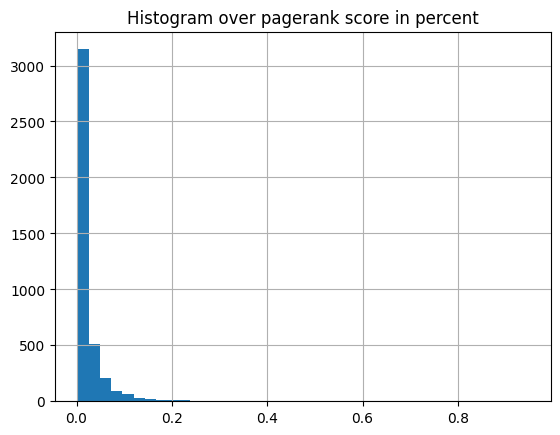

In [40]:
df_hubs.hist(column = "pagerank_hub_score_percent", bins = 40)
plt.title('Histogram over pagerank score in percent')
plt.show()

In [41]:
cols = ['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path', 'pagerank_hub_score']

p_values , correlation_matrix = calculate_correlation(df_hubs, cols)

print("p-values for correlation")
print(p_values)

p-values for correlation
[[0.00000000e+000 5.48709306e-320 7.73751945e-126 0.00000000e+000
  0.00000000e+000]
 [5.48709306e-320 0.00000000e+000 2.32898918e-130 3.81665358e-089
  0.00000000e+000]
 [7.73751945e-126 2.32898918e-130 0.00000000e+000 1.28800287e-099
  1.42461485e-160]
 [0.00000000e+000 3.81665358e-089 1.28800287e-099 0.00000000e+000
  7.43243307e-113]
 [0.00000000e+000 0.00000000e+000 1.42461485e-160 7.43243307e-113
  0.00000000e+000]]


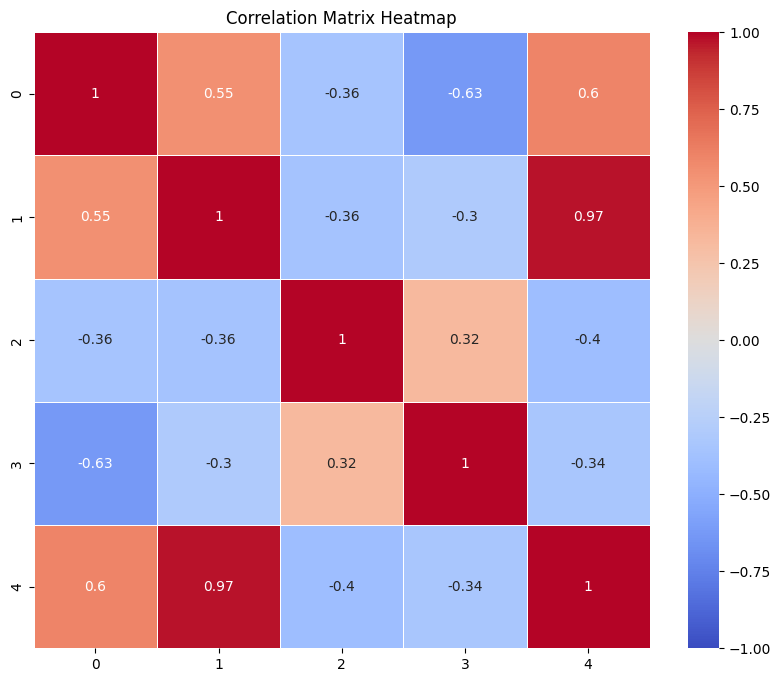

In [42]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

Highly correlated with target counts, and source counts, negatively correlated with mean shortest path and mean shortest path to article. I feel like we should present this in a table intead.

In [43]:
df_hubs["pagerank_hub_score_percent"].describe()

count    4135.000000
mean        0.023906
std         0.046008
min         0.001800
25%         0.004707
50%         0.009930
75%         0.024341
max         0.947544
Name: pagerank_hub_score_percent, dtype: float64

In [44]:
#score sums to 1
np.sum(df_hubs["pagerank_hub_score_percent"])

np.float64(98.85092621013601)

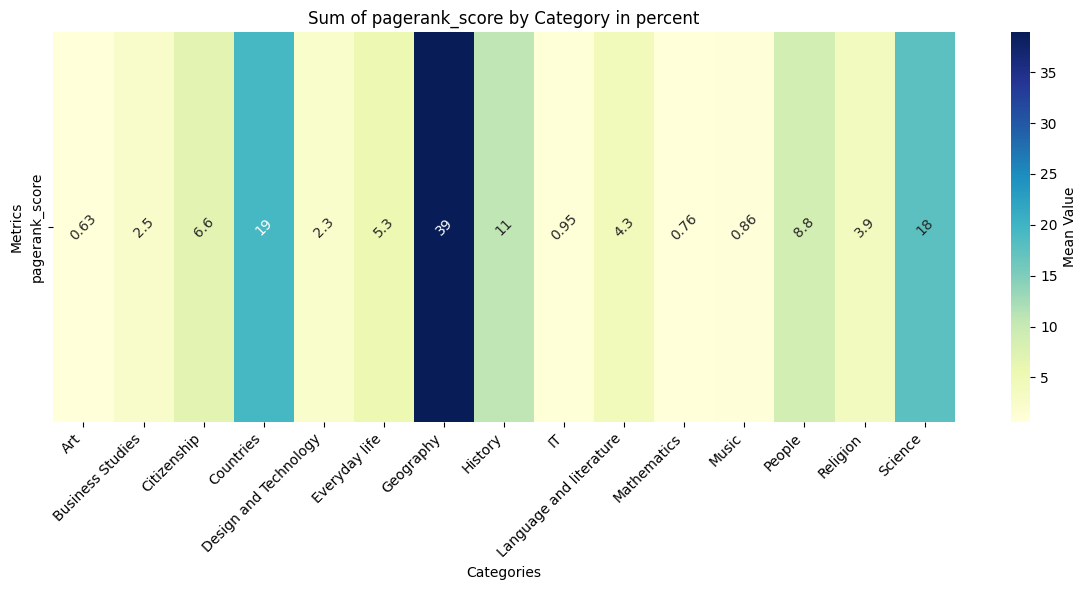

In [45]:
# Look at categories of information
mean_values = df_hubs[["pagerank_hub_score_percent"]].mean()
categories = df_hubs.columns[5:20]

# Create matrix for plotting
matrix = pd.DataFrame({
    "pagerank_score": df_hubs[categories].multiply(df_hubs["pagerank_hub_score_percent"], axis=0).sum()}).T
    #"target_counts": df_hubs[categories].multiply(df_hubs["target_counts"], axis=0).mean()}).T

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'}, annot_kws={'rotation': 45})
plt.title('Sum of pagerank_score by Category in percent')
plt.xlabel('Categories')
plt.ylabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Geography is the most important category. Has highest page rank score, then countries, then science.

#Calculate page rank score of connected articles. So what is the sum of the page rank score to other articles?

# Pagerank vs user frequency

In [26]:
freVpr = get_pageVSfreq_data(data, df_hubs)
plot_pageVSfreq(freVpr, category=None)

Due to the fact that most categories are spread out across all quadrants (most definetly dependent on the second-category and the fact that there always will be outliers) the categories of biggest interest are those that tend to a certain quadrant or have many big outliers more than the other ones. The quadrants of interest is the upper left and the lower right quadrants. The first one contains articles that on average is lesser connected yet still highly selected by the players with respect to how often they appear, indicating that these ones might constitute common knowledge more than other articles. The opposite can be said about the lower right quadrant, which therefore contains articles that might constitute lesser known concepts. 

Observations

- Geography is a scattered category that constitutes a large part of the biggest hubs and most frequently used articles by users. However, they also constitute the majority of the more connected articles that does not get used. More specifically, it seems like it is primarily contries that belong to this group, which differs from geography in the sense that the category is very shifted towards the lower right quadrant. Someething that is investigated in the next plot. 
- Science is also very scatterd, with a lot of big outliers in both the upper left and lower right quadrants. 
- Everyday life and IT seems to have some articles that are used more than average by users, yet still on average is less connected than other articles. IT is particularly interesting since its articles are heavily shifted up to the left, with 0 articles in the lower right quadrant. 

(Important not to get hooked on specific outliers since some players also have a good understaning of specific articles that are good for the game)

In [27]:
freVpr = get_pageVSfreq_data(data, df_hubs)
fig = plot_pageVSfreq(freVpr, category='Geography')

Observations
- The categories that have tends towards the upper left quadrant with bigger portion of outliers than other articles are North American Geography, General Geograhpy and Geology and Geophysics. 
- As stated before and can be seen in the first plot, countries constitute the absolute majority of all articles in the lower right quadrant. 

In [28]:
freVpr = get_pageVSfreq_data(data, df_hubs)
plot_pageVSfreq(freVpr, category='Everyday life')

Observation
- The majority of articles with a smaller pagerank score that yet have above average frequency by users belong to the "Film" and "Computer and Video games" categories. Where the articles in question are big popcultural phenomenon such as Star Wars, Nintendo and Mario. Something that is not that suprising that people have good knowledge in. 
- Sports constitutes the biggest part of the articles in "Everyday life" that are in the lower right quadrant. 


In [29]:
freVpr = get_pageVSfreq_data(data, df_hubs)
plot_pageVSfreq(freVpr, category='Science')

Observations: 
- Chemistry has almost no articles in the upper left quadrant but a lot in the lower right one.
- Physics is heavily scattered. The artiles in the upper left quadrant are almost all space related, while the ones in the lower right quadrant are more low-level physics.
- Biology is also scattered, where animals mostly make up the articles in the upper left quadrant while more low level articles constitute the articles in the lower right column. 

Total comparisons made: 254338
Paths with higher PageRank alternatives: 147831
Percentage: 58.12%


/Users/School/Desktop/ada-2024-project-adaventure/src/fork.py:102: RuntimeWarning:

invalid value encountered in divide



4604
Number of non-zero values in column_sums: 4495


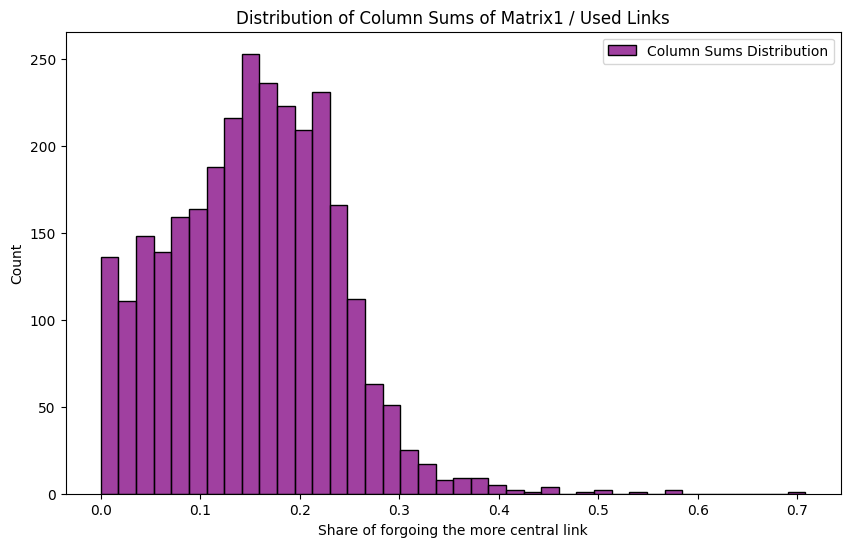

4604
                        Article  Forgone Value  Column Sums UL
433                        Bran       0.708333            24.0
2601              Thomas Edison       0.571429           126.0
1609               Lyme disease       0.566667            90.0
196                    Aquarium       0.546178           628.0
1704             Medieval music       0.500000            12.0
1711                 Meningitis       0.500000            74.0
966            Fertile Crescent       0.494585           277.0
537                    Cataract       0.454545            11.0
1020         Frank Lloyd Wright       0.454545            11.0
1870               Nikola Tesla       0.446367           289.0
2123                      Prion       0.443213           361.0
2341             Sea level rise       0.440000            50.0
1724  Metric expansion of space       0.424242            33.0
1109                 Glaciology       0.419355            31.0
682                 Cooperative       0.405063    

In [30]:
matrix1, matrix2, unused_links, article_names = load_fork_matrix(data, df_hubs)
forgone_articles_df = plot_badChoices(matrix1, unused_links, article_names)

This plot illustrates how often users bypass a more central article in favor of a less optimal one, focusing only on cases where alternative articles have the same or shorter shortest-path distance to the target. As expected, users frequently deviate from the optimal navigation path. Notably, some articles are overlooked more frequently than others, suggesting that users are less likely to consider these articles during navigation. Specifically, articles such as "Bran," "Thomas Edison," and "Lyme Disease" appear to be consistently neglected, indicating a lower level of awareness or recognition of these topics among players.

In [31]:
plot_forgone_vs_usage(forgone_articles_df)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
from src.hubs_frequency import get_hub_positions, plot_hub_positions
finished_hub_positions, unfinished_hub_positions, shortest_hub_positions = get_hub_positions(data, df_hubs)

In [ ]:
plot_hub_positions(df_hubs, finished_hub_positions, unfinished_hub_positions, shortest_hub_positions)

This plot reveals that in 50% of puzzles, the optimal strategy is to navigate to one of the top 5% most connected hubs with the first click. Most players tend to use these top hubs in their initial steps. Notably, successful players are more likely to utilize hubs within their first three steps compared to unsuccessful players, suggesting that early use of hubs improves navigation success.

/var/folders/56/trdty15x19s_tmgm65hm1_rc0000gp/T/ipykernel_71208/2723797592.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




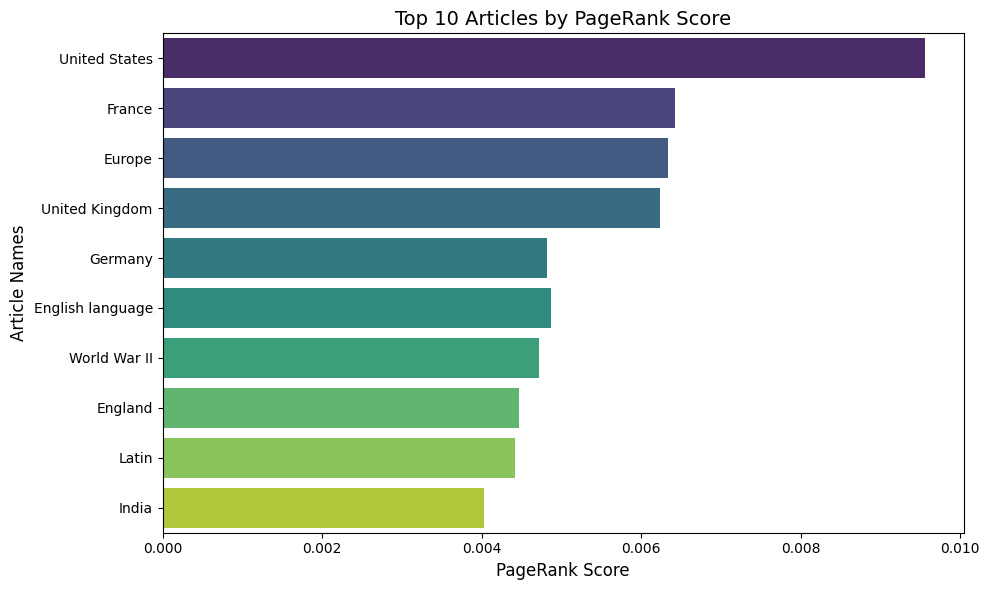

In [46]:
# Top 10 hubs viz
top_10_pr = df_hubs.sort_values(by="hub_score", ascending=False).head(10)

#bar plot 
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_pr,
    y="article_names",
    x="pagerank_score",
    palette="viridis"
)

# Add labels and title
plt.xlabel("PageRank Score", fontsize=12)
plt.ylabel("Article Names", fontsize=12)
plt.title("Top 10 Articles by PageRank Score", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

In [48]:
# Visualize all articles in 3d space, with size based on hub score

import plotly.graph_objects as go

# Generate positions for articles in 3D space using a random distribution
num_nodes = len(G.nodes())
x_vals = np.random.uniform(-0.2, 0.2, num_nodes)  # size of space
y_vals = np.random.uniform(-0.2, 0.2, num_nodes)  
z_vals = np.random.uniform(-0.2, 0.2, num_nodes)  

# Get PageRank scores and normalize them for point sizes
pagerank_scores = df_hubs.set_index("article_names")["hub_score"].to_dict()
sizes = [pagerank_scores.get(node, 0) * 3000 for node in G.nodes()] 
colors = [pagerank_scores.get(node, 0) for node in G.nodes()]  


# Create a Plotly 3D scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(
        size=sizes,
        color=colors,
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='PageRank Score')
    ),
    text=list(G.nodes()),  # Add node names for hover info
    hoverinfo='text'
))

# Update layout for better visualization
fig.update_layout(
    title='Interactive 3D Visualization of Articles by PageRank',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    paper_bgcolor='white',  # Blank background
    margin=dict(l=0, r=0, b=0, t=40)
)

# Display the interactive plot
fig.show()
